In [6]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import scipy

from tqdm import tqdm 

import os

import matplotlib.pyplot as plt
from neurorient import NeurOrient
from neurorient.utils_visualization import save_mrc, display_volumes, display_fsc
from neurorient.reconstruction.phasing import PhaseRetriever
from neurorient.metrics import compute_fsc
from neurorient.reconstruction.slicing import real_mesh_2_reciprocal_mesh

import h5py
from pytorch3d.transforms import matrix_to_quaternion

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
pdb = '1BXR'
poisson = True
num_images = 10000
increase_factor = 10

In [8]:
spi_data = torch.load(f'/pscratch/sd/z/zhantao/neurorient_repo/data/{pdb}_increase{increase_factor:d}_poisson{poisson}_num{num_images//1000:d}K.pt')
ckpt_path = '/pscratch/sd/z/zhantao/neurorient_repo/model/lightning_logs/version_15635334/checkpoints/1BXR-epoch=347-step=31240.ckpt'
save_dir = '/pscratch/sd/z/zhantao/neurorient_repo/data'
print(spi_data.keys())

dict_keys(['orientations', 'intensities', 'pixel_position_reciprocal', 'pixel_index_map', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [9]:
model = NeurOrient.load_from_checkpoint(ckpt_path)
scale_factor = model.photons_per_pulse * 1e-12

In [10]:
model.to(device)

grid_reciprocal = np.pi * model.grid_position_reciprocal / model.grid_position_reciprocal.max()
with torch.no_grad():
    intensity = model.predict_intensity(grid_reciprocal.to(device))
intensity_pred = (torch.exp(intensity) - 1).cpu().numpy() / scale_factor

In [11]:
model.grid_position_reciprocal.shape

torch.Size([128, 128, 128, 3])

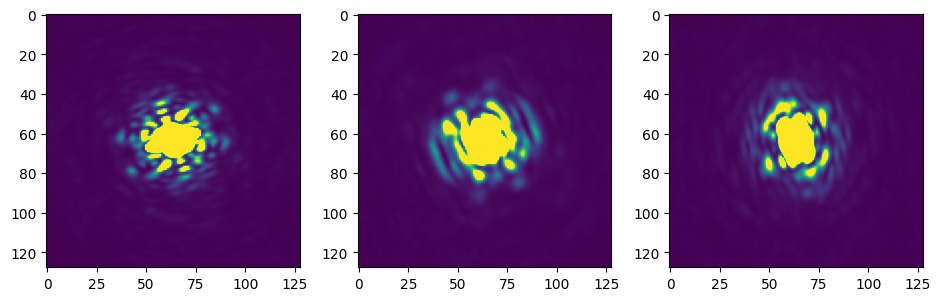

In [12]:
display_volumes(intensity_pred, closefig=False, vmin=0, vmax=1e-3 * intensity_pred.max())

In [13]:
phase_retriever = PhaseRetriever(n_phase_loops=10, beta_HIO=0.3, beta_DM=0.3, shrink_wrap_method='max')
rho_phased, support_phased = phase_retriever.phase(torch.from_numpy(intensity_pred.clip(intensity_pred.max() * 1e-5)).sqrt().to(device))

Phase Retrieval:   0%|          | 0/10 [00:00<?, ?it/s]

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Phase Retrieval: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


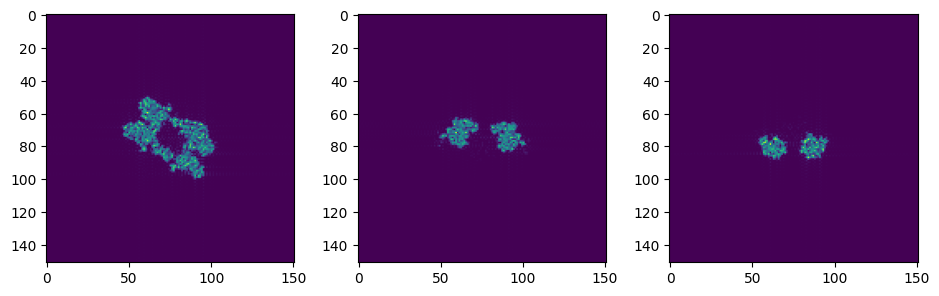

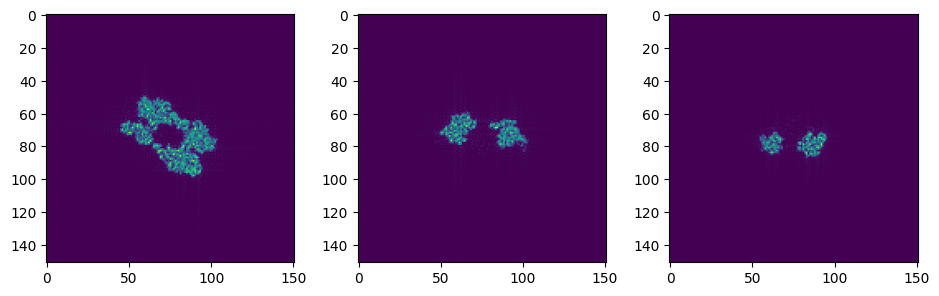

In [14]:
from neurorient.reconstruction.phasing import recenter

real_volume = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(spi_data['volume'])).real).clamp(0.)
display_volumes(real_volume, closefig=False)
real_volume = torch.fft.fftshift(recenter(
    torch.fft.ifftshift(real_volume), torch.ones_like(real_volume), M=real_volume.shape[-1]
)[0])
display_volumes(real_volume, closefig=False)

Initial CC between unzoomed / unfiltered volumes is: 0.380
Alignment CC after rotation is: 0.836
Final CC between unzoomed / unfiltered volumes is: 0.814
Estimated resolution from FSC: 24.4 Angstrom


/global/u2/z/zhantao/Projects/NeuralOrientationMatching/neurorient/utils_visualization.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.set_xticklabels([f"{1/q:.2f}" for q in ax1.get_xticks()])


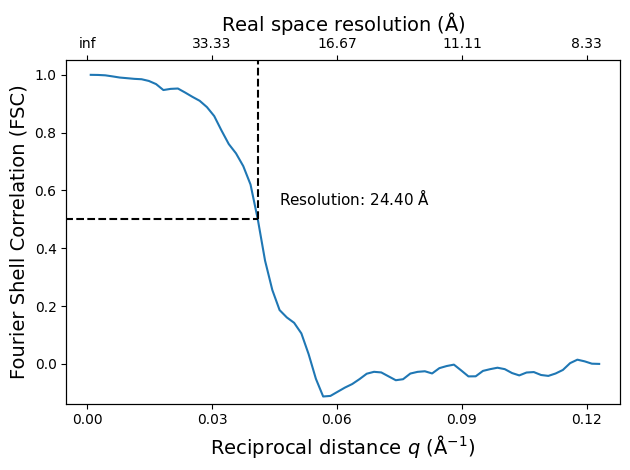

In [15]:
rho_cc, qshell, fsc = compute_fsc(
    real_volume, 
    spi_data['vol_real_mesh'], 
    rho_phased,
    model.grid_position_real,
    volume_type='electron_density')

display_fsc(qshell, fsc, resolution=rho_cc, closefig=False)

Initial CC between unzoomed / unfiltered volumes is: 0.699
Alignment CC after rotation is: 0.840
Final CC between unzoomed / unfiltered volumes is: 0.741
Estimated resolution from largest-q: at least 11.4 Angstrom


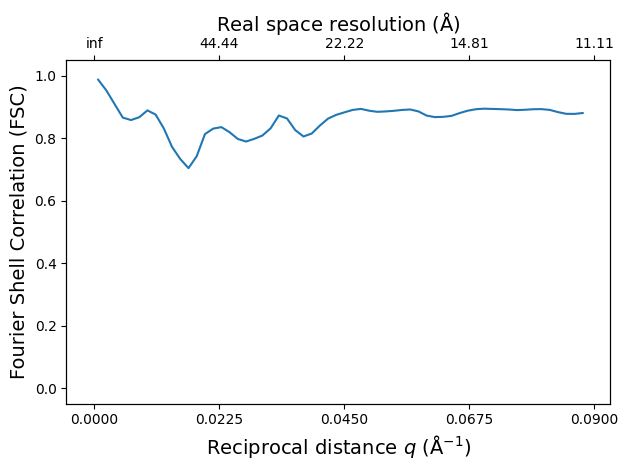

In [16]:
resolution, qshell, fsc = compute_fsc(
    spi_data['volume'].abs().pow(2) / spi_data['volume'].abs().pow(2).max(),
    real_mesh_2_reciprocal_mesh(spi_data['vol_real_mesh']), 
    intensity_pred/intensity_pred.max(),
    model.grid_position_reciprocal,
    volume_type='intensity')
display_fsc(qshell, fsc, closefig=False)

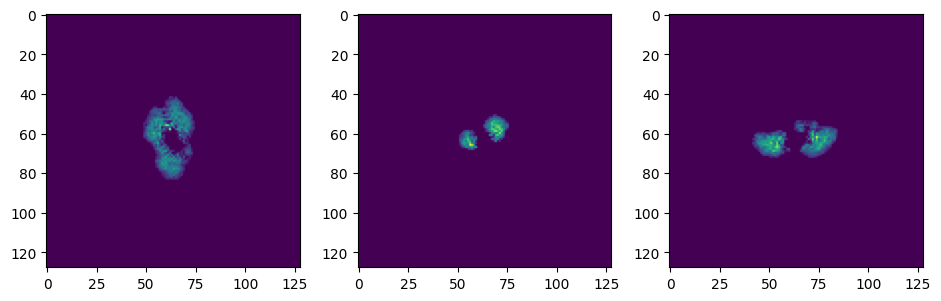

In [17]:
display_volumes(rho_phased, closefig=False, vmin=0)

In [18]:
save_mrc(f'{pdb}_pr.mrc', rho_phased.detach().cpu().numpy())